# Pytorch Text - Generating Names With A Character-Level RNN
Notebook for following along with Pytorch Text text interpretation tutorial, looking at basic character level RNN to generate names [Pytorch](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)  website tutorial. <br><br>
The data can be downloaded [here](https://download.pytorch.org/tutorial/data.zip).

### Choices for data

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [1]:
#Import cell
import glob
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import numpy as np
import os
import pandas as pd
import pickle as pk
import random
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import unicodedata

from __future__ import unicode_literals, print_function, division
from io import open

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(f"Device: {device}. Cuda available: {torch.cuda.is_available()}")
print("Imports complete")

Device: cuda. Cuda available: False
Imports complete


<br>

### Importing and preparing data sets
Importing and preparing the data for the models.

In [2]:
#Gather datasets and prepare them for consumption
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c)!= 'Mn' and c in all_letters)

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

print("Data sets functions defined.")

Data sets functions defined.


In [3]:
#Importing data sets
category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')


print("# categories: ", n_categories)
print(all_categories)
print(unicodeToAscii("O'Néàl"))
print("\nData sets successfully imported.")

# categories:  18
['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal

Data sets successfully imported.


In [4]:
#Loader definitions

print(f"Loaders defined, running on device: {device}")

Loaders defined, running on device: cuda


In [5]:
#Setting seed value
torch.manual_seed(1247)

<br>

### Class Definitions
<b>Classes:</b><br>
<ul>
    <li>TransformerModel - Language interpretting model.</li>
    <li>PositionalEncoding - Injects information about the relative or absolute position of tokens in the sequence.</li>
</ul>

In [6]:
#Class definition cell
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        return None
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
print("Classes defined.")

Classes defined.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
    <li>randomChoice - Returns random item from a list</li>
    <li>randomTrainingPair - get a random category and a random line from it</li>
    <li>randomTrainingExample - Make category, input and target tnesors from a random category, line pair</li>
    <li>categoryTensor - One-hot vector for category</li>
    <li>inputTensor - One-hot matrix of first to last letters (excluding EOS) for input</li>
    <li>targetTensor - Longtensor of second letter to end (EOS) for target)</li>
</ul>

In [7]:
#Calculation functions cell
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters-1) #EOS
    return torch.LongTensor(letter_indexes)

print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
    <li></li>
</ul>

In [8]:
#Plotting functions Cell

print("Plotting functions defined.")

Plotting functions defined.


<br>

### Main code
#### Creating the network

In [9]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_letters)
print("Network created.")

Network created.


#### Training The Network

In [10]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [11]:
#Function definitions
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()/input_line_tensor.size(0)


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' %(m, s)

In [12]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 #reset every plot_every iters
start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter%print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, 
                                     iter/n_iters*100, loss))
    if iter%plot_every == 0:
        all_losses.append(total_loss/plot_every)
        total_loss = 0

0m 14s (5000 5%) 2.6396
0m 27s (10000 10%) 2.6978
0m 41s (15000 15%) 2.0311
0m 54s (20000 20%) 1.9955
1m 7s (25000 25%) 1.7950
1m 20s (30000 30%) 3.0883
1m 33s (35000 35%) 1.9216
1m 46s (40000 40%) 1.3263
1m 59s (45000 45%) 2.6844
2m 13s (50000 50%) 1.9098
2m 27s (55000 55%) 1.9809
2m 40s (60000 60%) 2.6184
2m 53s (65000 65%) 1.3360
3m 7s (70000 70%) 2.6250
3m 20s (75000 75%) 2.6891
3m 35s (80000 80%) 1.2802
3m 50s (85000 85%) 1.3528
4m 3s (90000 90%) 2.2208
4m 15s (95000 95%) 2.4261
4m 28s (100000 100%) 2.1409


#### Plotting Results

Training Losses


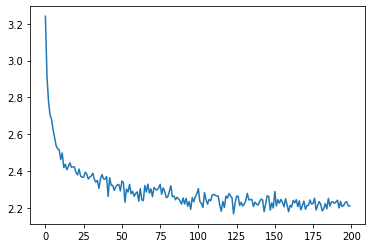

In [13]:
plt.figure()
plt.plot(all_losses)
print("Training Losses")

<br>